<a href="https://colab.research.google.com/github/navroz-lamba/DS-Unit-2-Linear-Models/blob/master/213_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

# Wrangle Our Data

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

!pip install category_encoders==2.*

In [ ]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', 
                 parse_dates=['created'],
                 index_col='created')

df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49352 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             49352 non-null  float64
 1   bedrooms              49352 non-null  int64  
 2   description           47906 non-null  object 
 3   display_address       49217 non-null  object 
 4   latitude              49352 non-null  float64
 5   longitude             49352 non-null  float64
 6   price                 49352 non-null  int64  
 7   street_address        49342 non-null  object 
 8   interest_level        49352 non-null  object 
 9   elevator              49352 non-null  int64  
 10  cats_allowed          49352 non-null  int64  
 11  hardwood_floors       49352 non-null  int64  
 12  dogs_allowed          49352 non-null  int64  
 13  doorman               49352 non-null  int64  
 14  dishwasher            49352 non-nul

In [ ]:
df.describe()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.00000
mean,1.21218,1.541640,40.741545,-73.955716,3.830174e+03,0.525126,0.476982,0.476759,0.446486,0.424887,0.413965,0.365983,0.052541,0.268520,0.185423,0.177055,0.132821,0.138677,0.104089,0.087190,0.060686,0.055357,0.051852,0.046847,0.043929,0.042612,0.039370,0.027517,0.02620
std,0.50142,1.115018,0.638535,1.177912,2.206687e+04,0.499373,0.499475,0.499465,0.497133,0.494331,0.492547,0.481710,0.223117,0.443194,0.388644,0.381719,0.339385,0.345613,0.305379,0.282116,0.238757,0.228679,0.221730,0.211313,0.204940,0.201983,0.194476,0.163585,0.15973
min,0.00000,0.000000,0.000000,-118.271000,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.00000,1.000000,40.728300,-73.991700,2.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.00000,1.000000,40.751800,-73.977900,3.150000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.00000,2.000000,40.774300,-73.954800,4.100000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10.00000,8.000000,44.883500,0.000000,4.490000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


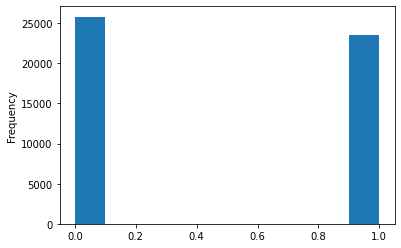

In [ ]:
df.cats_allowed.plot(kind='hist')

In [ ]:
df.select_dtypes('object').head()

,description,display_address,street_address,interest_level
created,,,,
2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,792 Metropolitan Avenue,medium
2016-06-12 12:19:27,,Columbus Avenue,808 Columbus Avenue,low
2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,241 W 13 Street,high
2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,333 East 49th Street,low
2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,500 West 143rd Street,low


In [ ]:
df.description.value_counts()

# Split Data

In [ ]:
# Split FM and TV
y = df.price
X = df.drop(['price', 'description', 'display_address', 'street_address'], axis=1)

In [ ]:
# Use data from April & May 2016 to train
# Use data from June 2016 to test
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [ ]:
# Sanity check
assert X_train.shape[0] + X_val.shape[0] == X.shape[0]

#  Establish Baseline

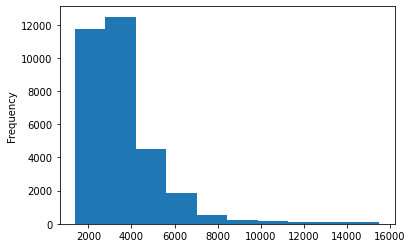

In [ ]:
y_train.plot(kind='hist')

In [ ]:
from sklearn.metrics import mean_absolute_error

print('Baseline MAE:', mean_absolute_error(y_train, [y_train.mean()]*len(y_train)))

Baseline MAE: 1201.8811133682555


# Build Model

## Transformer #1: One hot encoding

In [ ]:
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [ ]:
# Instantiate Transformer
ohe = OneHotEncoder(cols=['interest_level'], use_cat_names=True)

# Transform Feature Matrix
XT_train = ohe.fit_transform(X_train)

# Instantiate Predictor
model = LinearRegression()

# Fit on the TRANSFORMED data
model.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred_train = model.predict(XT_train)

# Note that we DON'T retrain the transformer
XT_val = ohe.transform(X_val)
y_pred_val = model.predict(XT_val)

In [ ]:
print('Training MAE:', mean_absolute_error(y_train, y_pred_train))
print('Validation MAE:', mean_absolute_error(y_val, y_pred_val))

Training MAE: 673.1551409557138
Validation MAE: 676.1110962539769


In [ ]:
model.score(XT_val, y_val)

0.6480261897419933

## Transformer #2: SelectKBest

In [ ]:
len(X_train.columns)

29

In [ ]:
from sklearn.feature_selection import SelectKBest

k_values = list(range(1,len(X_train.columns)+1))
r2_scores = []

for k in k_values:
  # Instantiate Transformer 1
  ohe = OneHotEncoder(cols=['interest_level'], use_cat_names=True)

  # Fit_transform 1
  XT_train = ohe.fit_transform(X_train)

  # Instantiate Transformer 2
  skb = SelectKBest(k=k)

  # Fit_transform 2
  XTT_train = skb.fit_transform(XT_train, y_train)

  # Instantiate Predictor
  model = LinearRegression()

  # Fit on the DOUBLE-TRANSFORMED data
  model.fit(XTT_train, y_train)

  # Get R^2 score
  r2_scores.append(model.score(XTT_train, y_train))

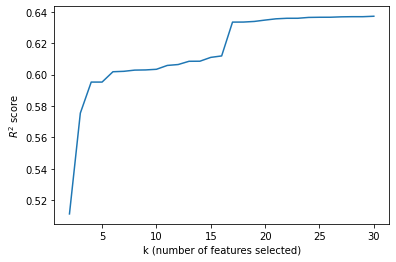

In [ ]:
import matplotlib.pyplot as plt
plt.plot(k_values, r2_scores)
plt.xlabel('k (number of features selected)')
plt.ylabel('$R^2$ score');

## Predictor: Ridge

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
model2 = Ridge()
model2.fit(XT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
model2.score(XT_val, y_val)

0.6479903964652333